# Parallelize code with `dask.delayed`

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`.

* Basics
* Parallelize with the dask.delayed decorator
* Dask delayed annotation
* Parallelize a for loop
---

- Authors: NCI Virtual Research Environment Team
- Keywords: Xarray, Dask, Diagnostics
- Create Date: 2020-May
- Lineage/Reference: This tutorial is referenced to [dask-tutorial](https://github.com/dask/dask-tutorial).
---

## Set up

Choose from the following two options to create a client:

In [1]:
# If you run this notebook on your local computer or NCI's VDI instance, you can create cluster
from dask.distributed import Client
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:43647' processes=4 threads=8, memory=33.56 GB>


In [1]:
# If you run this notebook on Gadi under pangeo environment, you can create cluster using scheduler.json file
from dask.distributed import Client, LocalCluster
client = Client(scheduler_file='scheduler.json')
print(client)

<Client: 'tcp://10.6.21.68:8773' processes=8 threads=48, memory=202.48 GB>


Starting the Dask Client will provide a dashboard which is useful to gain insight into the computation. The link to the dashboard will become visible when you create the Client. We recommend having the Client open on one side of your screen and your notebook open on the other side, which will be useful for learning purposes.

## Basics

Let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally and in the following section we'll parallelize these functions.

In [2]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [3]:
%%time
# This takes three seconds to run because we call each function sequentially, one after the other.

x = inc(1)
y = inc(2)
z = add(x, y)
z

CPU times: user 2.23 ms, sys: 809 µs, total: 3.04 ms
Wall time: 3 s


5

### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called *in parallel*.

We'll wrap the `inc` and `add` functions in the `dask.delayed` decorator. When we call the delayed version by passing the arguments, the original function isn't actually called yet.
Instead, a *task graph* is built up, representing the *delayed* function call.

In [4]:
from dask import delayed

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)
z

CPU times: user 809 µs, sys: 429 µs, total: 1.24 ms
Wall time: 939 µs


Delayed('add-e4a3d381-ee25-4536-a1b9-9f7f03620f3e')

This ran immediately, since nothing has really happened yet (i.e, variable `z` does not return any value but rather returns a delayed object).

To get the result, call `compute()`.

In [6]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 9 ms, sys: 0 ns, total: 9 ms
Wall time: 2.03 s


5

## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result.  We can compute the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [7]:
z

Delayed('add-e4a3d381-ee25-4536-a1b9-9f7f03620f3e')

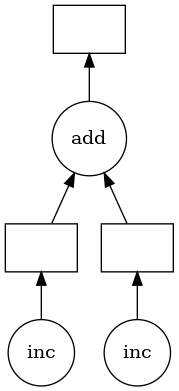

In [8]:
# Look at the task graph for `z`
z.visualize()

We can visualize the chain of calculations that the object `total` corresponds to as follows: the circles are functions, rectangles are data/results.

### Dask Delayed annotation

Dask allows you to construct a prescription for the calculation you want to carry out. This is an alternative way to utilize dask.delayed functions. You can achieve this while programming with perfectly ordinary Python functions and for-loops.

In [9]:
from dask import delayed

@delayed
def inc(x):
    return x + 1

@delayed
def add(x, y):
    return x + y

Instead of using the `dask.delayed` function (i.e., `delayed(inc)`) as in the previous session, here we use the delayed annotation to show that we want these functions to operate lazily which will save the set of inputs and execute only on demand. 

In [10]:
# this looks like ordinary code
x = inc(15)
y = inc(30)
total = add(x, y)
# x, y and total are all delayed objects. 
# They contain a prescription of how to execute

Calling a delayed function created a delayed object (`x, y, total`). Making these objects is somewhat equivalent to constructs like the `lambda` or function wrappers (see below). Each holds a simple dictionary describing the task graph and a full specification of how to carry out the computation.

**Why should you care about this?**

By building a specification of the calculation we want to carry out before executing anything, we can pass the specification to an *execution engine* for evaluation. In the case of Dask, this execution engine could be running on many nodes of a cluster, so you have access to the full number of CPU cores and memory across all the machines. Dask will intelligently execute your calculation with care for minimizing the amount of data held in memory, while parallelizing over the tasks that make up a graph. Notice that in the animated diagram below, where four workers are processing the (simple) graph, execution progresses vertically up the branches first, so that intermediate results can be expunged before moving onto a new branch.

With `delayed` and normal Pythonic looped code, very complex graphs can be built up and passed on to Dask for execution. See a nice example of the [simulated complex ETL](https://blog.dask.org/2017/01/24/dask-custom) work flow.

![this](images/grid_search_schedule.gif)

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s?
-  What would have happened if the inc and add functions didn't include `sleep(1)`?  Would Dask still be able to speed up this code?

## Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [11]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [12]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 1.11 ms, sys: 466 µs, total: 1.58 ms
Wall time: 1.31 ms


In [13]:
total

Delayed('add-6ad231e85634c2cefc26deb5747e5f1f')

In [14]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('sum-d7c19d23-a5fc-4a26-ad56-2c961c0e2ce9')
After computing : 44
CPU times: user 7.06 ms, sys: 4.75 ms, total: 11.8 ms
Wall time: 43.7 ms


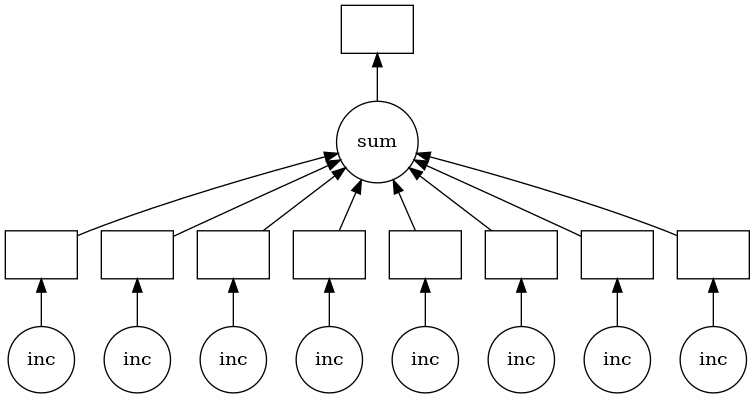

In [15]:
total.visualize()

## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision to delay or not to delay requires careful thought when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [16]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [17]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

Delayed('add-8f939fb842c5106f0fc7e7d57e1cec0f')
CPU times: user 5.6 ms, sys: 0 ns, total: 5.6 ms
Wall time: 5 s


In [18]:
%%time
# lazy version

results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

CPU times: user 2.5 ms, sys: 24 µs, total: 2.52 ms
Wall time: 1.77 ms


In [19]:
%time total.compute()

CPU times: user 8.26 ms, sys: 0 ns, total: 8.26 ms
Wall time: 1.04 s


90

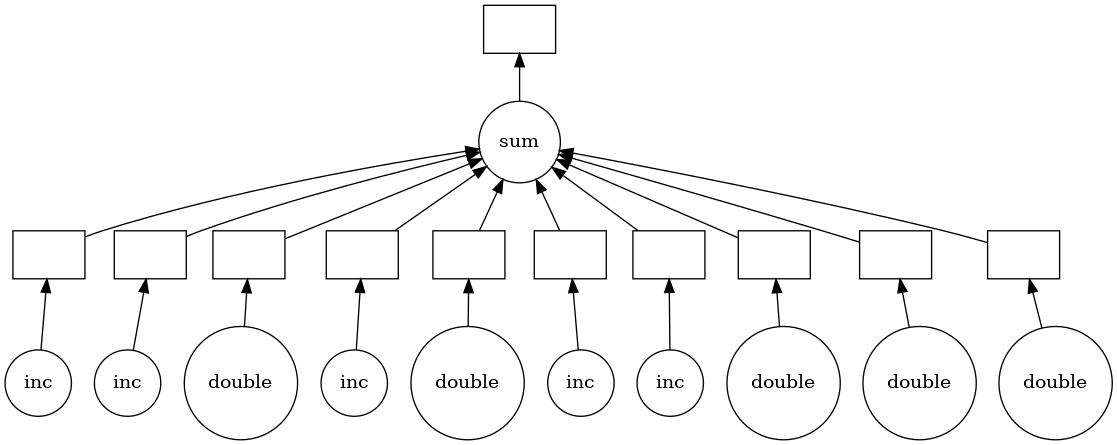

In [20]:
total.visualize()

### Close the client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [21]:
client.close()

### Some questions to consider:

-  What are other examples of control flow where we can't use `dask.delayed`?
-  What would have happened if we had delayed the evaluation of `is_even(x)` in the example above?
-  What are your thoughts on delaying `sum`?  This function is both computational but also fast to run.

**Notes**

Delayed objects support various operations:
```python
    x2 = x + 1
```

If `x` was a delayed result (like `total`, above), then so is `x2`. Supported operations include arithmetic operators, item or slice selection, attribute access and method calls - essentially anything that could be phrased as a `lambda` expression.

Operations which are *not* supported include mutation, setter methods, iteration (for) and bool (predicate).

### Summary

This example shows some basic concepts of dask delayed functions and how to parallelize the for-loop using `dask.delayed`.

## Reference

https://docs.dask.org/en/latest/delayed.html